<a href="https://colab.research.google.com/github/insoucyant/MachineLearning/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://www.youtube.com/watch?v=q_HS4s1L8UI&t=248s
# https://www.youtube.com/watch?v=zN49HdDxHi8
# https://www.youtube.com/watch?v=Sj-gIb0QiRM
# Import the libraries
import pandas as pd
import numpy as np
from copy import deepcopy as dc
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
#!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

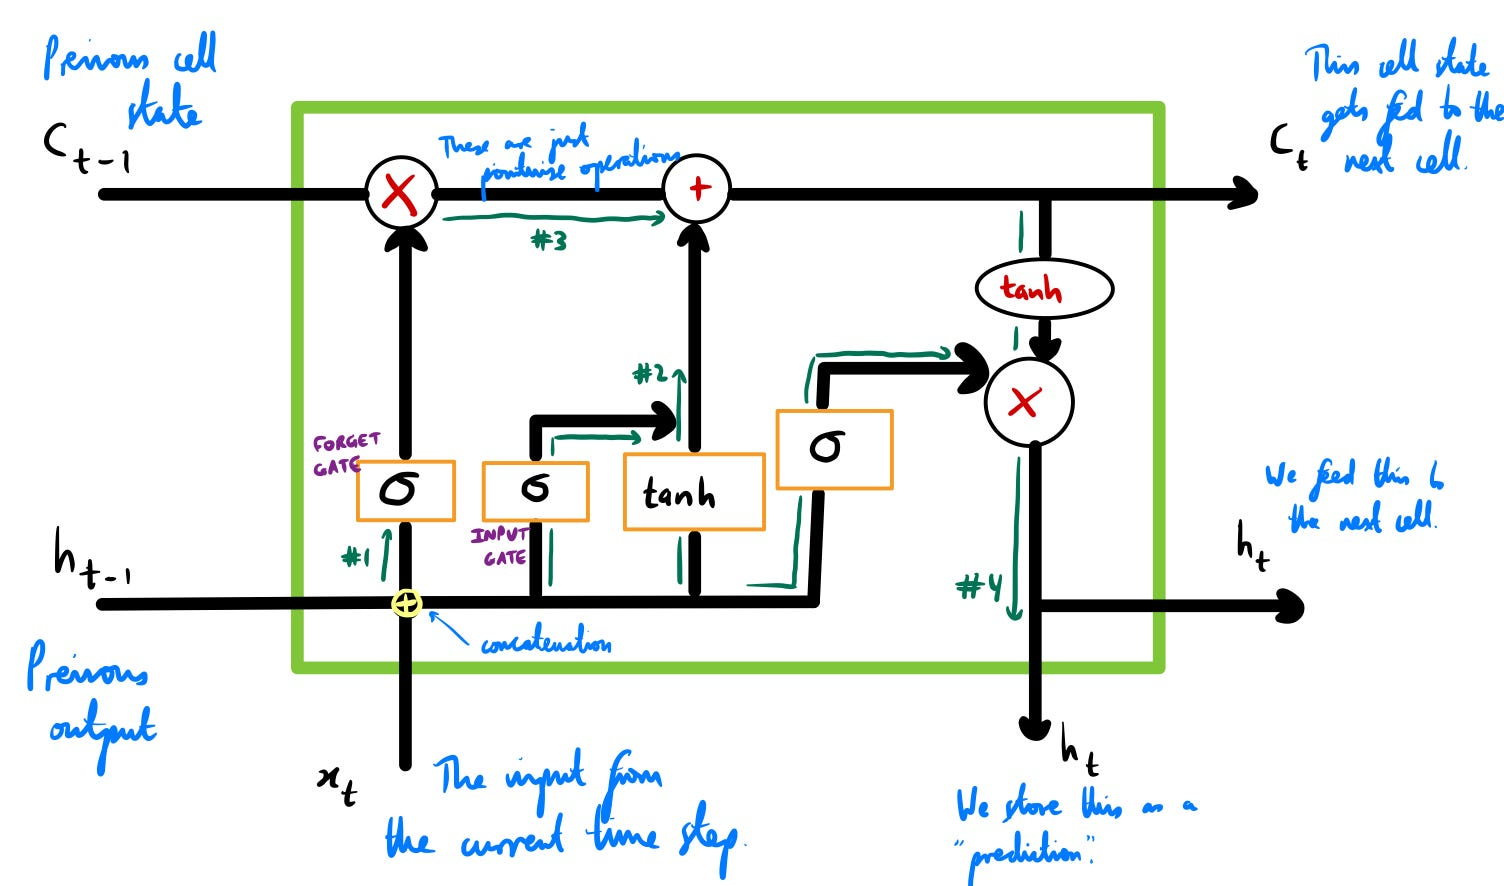

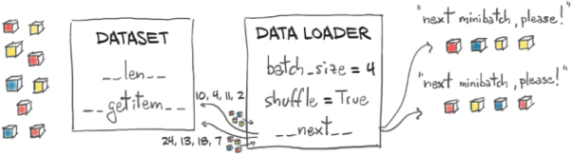

* One **epoch** = one forward pass and one backward pass of all the training examples
* **batch_size** = The number of training examples in one forward/backward pass. The higher the batch size, the more memory space you will need
* number of **iterations** = number of passes, each pass using [batch size] number of examples \
One pass = one forward pass+ one backward pass. e.g., If you have 1000
training examples, and your bacth size is 500, then it will take two
iterations to complete 1 epoch. %%

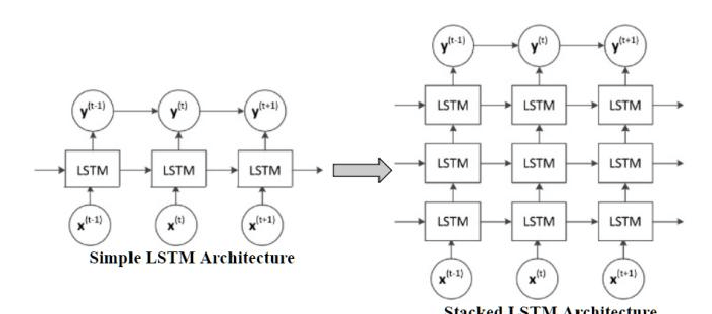

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
stock = 'Indigo'
Indigo_in = yf.Ticker("INDIGO.NS")
# get stock info
# print(Indigo_in.info)

In [4]:
# get historical market data
data_in = Indigo_in.history(period="4400d")
data_in.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-11-10 00:00:00+05:30,811.290167,852.717359,804.843844,831.624573,27351793,0.0,0.0
2015-11-13 00:00:00+05:30,870.255186,978.326091,869.307196,951.877136,8446622,0.0,0.0
2015-11-16 00:00:00+05:30,958.418314,985.910036,915.995743,937.515137,3358159,0.0,0.0
2015-11-17 00:00:00+05:30,938.510480,995.295127,925.428225,982.971252,3694092,0.0,0.0
2015-11-18 00:00:00+05:30,964.343283,1013.212237,962.494691,991.266235,3621593,0.0,0.0


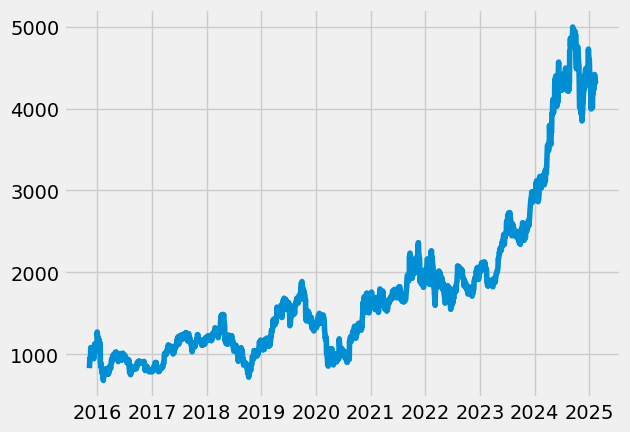

In [5]:
df_close = data_in[['Close']]
plt.plot(df_close)

In [6]:
def prepare_data_for_lstm(data, look_back):
  df = dc(data)
  df = df[['Close']]

  for i in range(1, look_back+1):
    df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace=True)

  return df
LOOKBACK = 7
shifted_df = prepare_data_for_lstm(data_in, LOOKBACK)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2015-12-23 00:00:00+05:30,1121.520142,1104.171753,1025.725586,1079.998047,1128.914307,1130.668213,1123.795044,1036.200928
2015-12-24 00:00:00+05:30,1103.887329,1121.520142,1104.171753,1025.725586,1079.998047,1128.914307,1130.668213,1123.795044
2015-12-28 00:00:00+05:30,1132.042847,1103.887329,1121.520142,1104.171753,1025.725586,1079.998047,1128.914307,1130.668213
2015-12-29 00:00:00+05:30,1124.743286,1132.042847,1103.887329,1121.520142,1104.171753,1025.725586,1079.998047,1128.914307
2015-12-30 00:00:00+05:30,1131.189575,1124.743286,1132.042847,1103.887329,1121.520142,1104.171753,1025.725586,1079.998047
...,...,...,...,...,...,...,...,...
2025-02-06 00:00:00+05:30,4394.850098,4415.399902,4345.200195,4393.700195,4324.350098,4227.750000,4293.899902,4282.500000
2025-02-07 00:00:00+05:30,4364.549805,4394.850098,4415.399902,4345.200195,4393.700195,4324.350098,4227.750000,4293.899902
2025-02-10 00:00:00+05:30,4325.149902,4364.549805,4394.850098,4415.399902,4345.200195,4393.700195,4324.350098,4227.750000


In [7]:
shifted_df_as_np = shifted_df.to_numpy()
scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
X = shifted_df_as_np[:,1:]
y = shifted_df_as_np[:,0]
X.shape, y.shape

((2258, 7), (2258,))

In [8]:
X = dc(np.flip(X, axis=1))
X

array([[-0.83585299, -0.79522851, -0.79204086, ..., -0.81554072,
        -0.84071125, -0.80432942],
       [-0.79522851, -0.79204086, -0.79285429, ..., -0.84071125,
        -0.80432942, -0.79628356],
       [-0.79204086, -0.79285429, -0.81554072, ..., -0.80432942,
        -0.79628356, -0.80446133],
       ...,
       [ 0.64432648,  0.68912776,  0.72129101, ...,  0.73135492,
         0.72182431,  0.70777162],
       [ 0.68912776,  0.72129101,  0.69879764, ...,  0.72182431,
         0.70777162,  0.68949869],
       [ 0.72129101,  0.69879764,  0.73135492, ...,  0.70777162,
         0.68949869,  0.6856494 ]])

In [9]:
split_index = int(len(X)*0.75)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1693, 7), (565, 7), (1693,), (565,))

In [10]:
X_train = X_train.reshape((-1,LOOKBACK,1))
X_test = X_test.reshape((-1,LOOKBACK,1))

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1693, 7, 1), (565, 7, 1), (1693, 1), (565, 1))

In [11]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([1693, 7, 1]),
 torch.Size([1693, 1]),
 torch.Size([565, 7, 1]),
 torch.Size([565, 1]))

In [12]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_dataset

In [13]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [14]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([16, 7, 1]) torch.Size([16, 1])


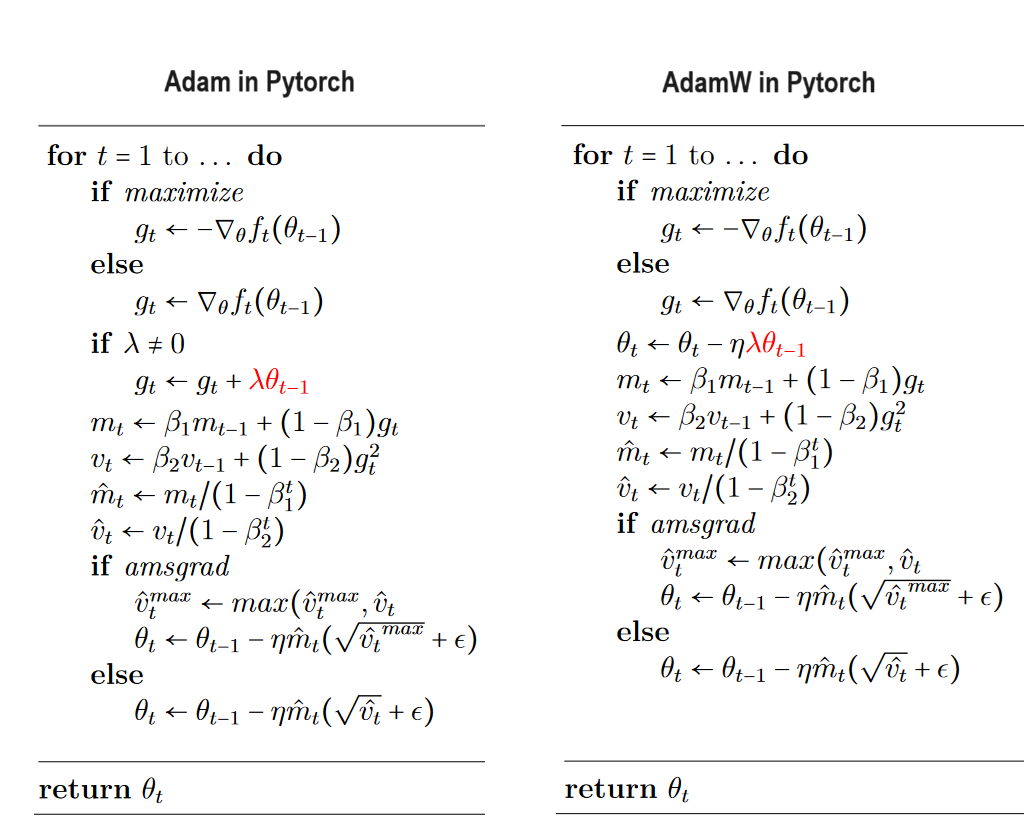

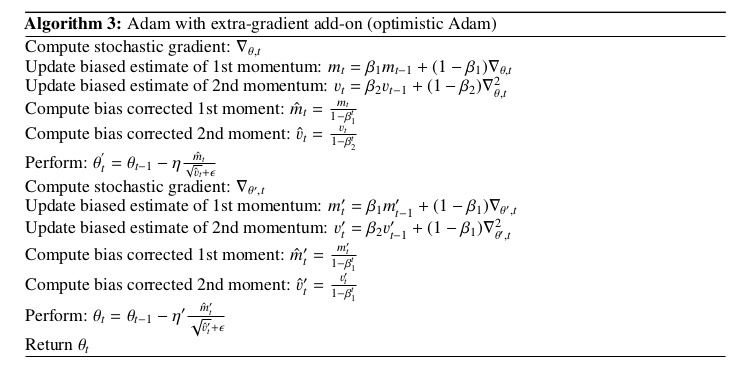

In [18]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers, output_size=1):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.LSTM = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0,c0))
    out = self.fc(out[:, -1, :])

model = LSTM(1,4,1)
model.to(device)
model

LSTM(
  (LSTM): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch():
  model.train(True)


In [ ]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  train_one_epoch()
  validate_one_epoch()